In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import sys
import urllib.request
from datetime import datetime, time
import string
from tqdm import tqdm
import time as t
import seaborn as sns
from scipy.stats import pearsonr, shapiro, levene, spearmanr
import ast

In [ ]:
rate = pd.read_csv('/content/전체시청률.csv', parse_dates = ['방송일자'])

In [ ]:
meta = pd.read_csv('/content/메타_전처리1.csv').iloc[:,:16]
meta = meta.drop(316).reset_index(drop = True)
meta['시작시간'] = pd.to_datetime(meta['시작시간'], format='%H:%M').dt.time

# 검색량 찾기 함수
def df_search(keyword, details, stardate, enddate, ages, gender, device = 'mo', timeunit = 'date'):  
keyword = ['멜로가체질', '천우희', '패션'] # keyword list  
details = [['멜로가체질'], ['천우희'], ['패션', '옷', '블라우스']] # 세부검색  
startdate = '2019-01-01' # 시작날짜 형식:2022-01-03  
enddate = '2020-01-01' # 종료날짜  
ages = ['1','2','3'] # 연령대 1:0-12, 2:13-18, 3:19-24, 4:25-29, 5:30-34, 6:35-39, 7:40-44, 8:45-49, 9:50-54, 10:55-59, 11:60- 미입력시 전체  
gender = 'f' # 성별 m:남, f:여 미입력시 전체  
device = 'pc' # 검색도구 pc:pc, mo:모바일 미입력시 전체  
timeunit = 'date' # 시간단위 date:일간, week:주간, month:월간  

In [ ]:
client_id = "CPVW7YCGr2hf9gEz_kA0"        # api 써넣기
client_secret = "LzETXT6Tw6"
url = "https://openapi.naver.com/v1/datalab/search";

In [ ]:
def df_search(keyword, details, startdate, enddate, ages, gender, device = 'mo', timeunit = 'date'):
  body = "{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";
  body_json = json.loads(body)
  body_json['startDate'] = startdate
  body_json['endDate'] = enddate
  body_json['timeUnit'] = timeunit
  body_json['device'] = device
  if ages != '':
    body_json['ages'] = ages
  else:
    body_json['ages'] = ['1','2','3', '4','5','6','7', '8', '9', '10', '11']
  body_json['gender'] = gender

  body_json['keywordGroups'] = []
  for i in range(len(keyword)):
    body_json['keywordGroups'].append( {'groupName': f'{keyword[i]}', 'keywords': details[i]} )
  body = json.dumps(body_json, ensure_ascii=False)


  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if(rescode==200):
      response_body = response.read()
      response_data = response_body.decode('utf-8')
  else:
      print("Error Code:" + rescode)

  result = json.loads(response_data)
  df = pd.DataFrame()

  # Iterate through each item in the 'results' list
  for item in result['results']:
      item_df = pd.DataFrame(item['data']).set_index('period')
      item_df.columns = [item['title']]

      # Append this DataFrame to the main DataFrame
      df = pd.concat([df, item_df], axis=1)

  df.fillna(0, inplace = True)
  df.reset_index(inplace=True)

  df['period'] = pd.to_datetime(df['period'])
  df.sort_values('period', inplace=True)
  df = df.reset_index(drop = True)

  return df

# 시청률과 검색량의 간극 - 9시 30분~10시 30분 드라마

## 함수

In [ ]:
def modify_detail(search_word, add_word, add = True):
  if add == True:
    for sub_list in detail_list:
      if search_word in sub_list:
        index2change = detail_list.index(sub_list)
        print(index2change, detail_list[index2change])
        detail_list[index2change].append(add_word)
        print(detail_list[index2change])
  else:
     for sub_list in detail_list:
      if search_word in sub_list:
        index2change = detail_list.index(sub_list)
        print(index2change, detail_list[index2change])


In [ ]:
def return_search_info(title):
  k = meta.loc[meta['작품명'] == title]
  keyword = [title, '기준']
  startdate = k.iloc[0, 5][:10]
  enddate = k.iloc[0, 6][:10]
  return keyword, startdate, enddate

## 검색 전처리

In [ ]:
# 9시 반부터 10시 반까지
night_list = meta.loc[(meta['시작시간'] >= time(9, 30)) & (meta['시작시간'] < time(10, 30)), '작품명'].tolist()

In [ ]:
translator = str.maketrans('', '', f'{string.punctuation} ')
# 특수문자 지우고, : 이나 -로 부제 달린 것들은 앞에 것만 반영
x_list = [[x, x.split(':')[0], x.split('-')[0], x.translate(translator)] for x in night_list]

# 동일한 인자는 지우기
detail_list = []
for sub_list in x_list:
    detail_list.append(list(set(sub_list)))
    detail_list_2 = detail_list.copy()
print(detail_list_2)

[['동네변호사 조들호 2', '동네변호사 조들호 2: 죄와 벌', '동네변호사조들호2죄와벌'], ['왕이된남자', '왕이 된 남자'], ['왜그래풍상씨', '왜그래 풍상씨'], ['봄이 오나 봄', '봄이오나봄'], ['진심이닿다', '진심이 닿다'], ['트랩'], ['눈이 부시게', '눈이부시게'], ['아이템'], ['해치'], ['열혈사제'], ['빅이슈'], ['사이코메트리 그녀석', '사이코메트리그녀석'], ['닥터프리즈너', '닥터 프리즈너'], ['킬잇'], ['으라차차와이키키2', '으라차차 와이키키 2'], ['더뱅커', '더 뱅커'], ['국민여러분', '국민 여러분!'], ['특별근로감독관조장풍', '특별근로감독관 조장풍'], ['그녀의사생활', '그녀의 사생활'], ['녹두꽃'], ['어비스'], ['초면에사랑합니다', '초면에 사랑합니다'], ['보이스3공범들의도시', '보이스 3 - 공범들의 도시', '보이스 3 '], ['절대 그이', '절대그이'], ['단하나의사랑', '단, 하나의 사랑'], ['바람이 분다', '바람이분다'], ['퍼퓸'], ['검색어를 입력하세요 WWW', '검색어를입력하세요WWW'], ['60일지정생존자', '60일, 지정생존자'], ['왓쳐'], ['저스티스'], ['닥터 탐정', '닥터탐정'], ['의사요한'], ['열여덟의 순간', '열여덟의순간'], ['악마가 너의 이름을 부를 때', '악마가너의이름을부를때'], ['너의노래를들려줘', '너의 노래를 들려줘'], ['17세의조건', '17세의 조건'], ['위대한 쇼', '위대한쇼'], ['생일편지'], ['꽃파당: 조선혼담공작소', '꽃파당', '꽃파당조선혼담공작소'], ['동백꽃필무렵', '동백꽃 필 무렵'], ['시크릿부티크', '시크릿 부티크'], ['배가본드'], ['청일전자미쓰리', '청일전자 미쓰리'], ['조선로코녹두전', '조선로코', '조선로코-녹두전'], ['레버리지사기조작단', '레버리지: 사기조작단', '레버리지'], ['유령

In [ ]:
modify_detail('동네변호사 조들호 2', '동네변호사 조들호')
modify_detail('검색어를 입력하세요 WWW', '검블유')
modify_detail('싸이코패스 다이어리', '싸패다')
modify_detail('왜 오수재인가?', '왜오수재인가')
modify_detail('금혼령, 조선 혼인 금지령', '금혼령')
modify_detail('낭만닥터 김사부 3', '김사부 3')


modify_detail('조선로코', 'ㅇㄹ', add = False)
modify_detail('보쌈 ', 'ㅇㄹ', add = False)
detail_list[44] = ['조선로코 녹두전', '녹두전', '조선로코-녹두전']
detail_list[97] = ['보쌈 - 운명을 훔치다', '보쌈 운명을 훔치다']

27 ['검색어를 입력하세요 WWW', '검색어를입력하세요WWW']
['검색어를 입력하세요 WWW', '검색어를입력하세요WWW', '검블유']
49 ['싸이코패스 다이어리', '싸이코패스다이어리']
['싸이코패스 다이어리', '싸이코패스다이어리', '싸패다']
125 ['왜 오수재인가?', '왜오수재인가']
['왜 오수재인가?', '왜오수재인가', '왜오수재인가']
141 ['금혼령조선혼인금지령', '금혼령, 조선 혼인 금지령']
['금혼령조선혼인금지령', '금혼령, 조선 혼인 금지령', '금혼령']
150 ['낭만닥터김사부3', '낭만닥터 김사부 3']
['낭만닥터김사부3', '낭만닥터 김사부 3', '김사부 3']
44 ['조선로코녹두전', '조선로코', '조선로코-녹두전']
97 ['보쌈 - 운명을 훔치다', '보쌈운명을훔치다', '보쌈 ']


## 시청률

<ipython-input-51-2c6ebc5ad15a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = rate[rate['작품명'].isin(night_list)].groupby('방송일자').mean()['시청률'].reset_index()


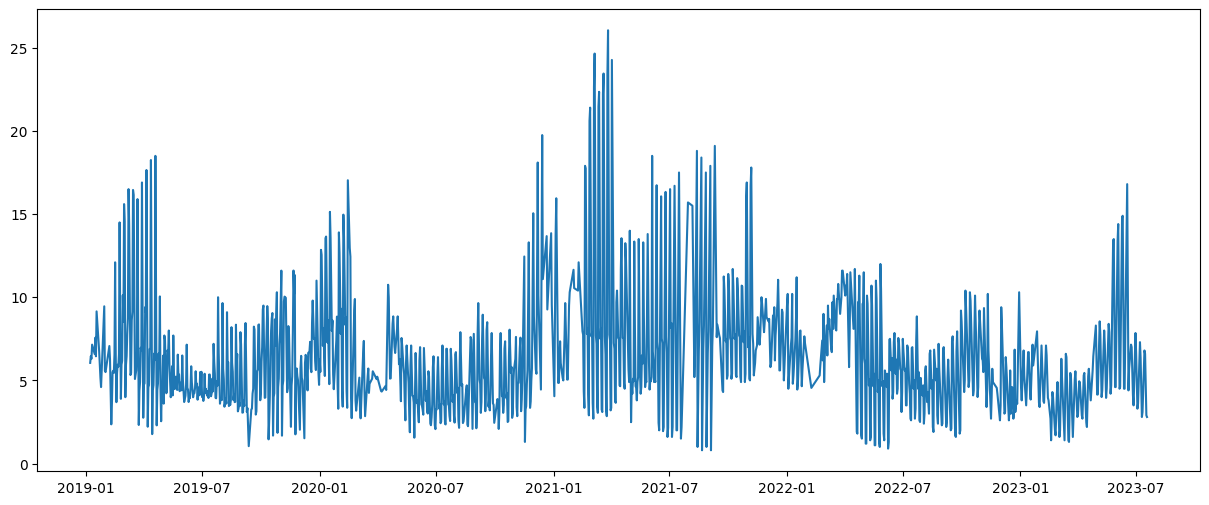

In [ ]:
x = rate[rate['작품명'].isin(night_list)].groupby('방송일자').mean()['시청률'].reset_index()

plt.figure(figsize = (15, 6))
plt.plot(x['방송일자'], x['시청률'])
plt.show()

## 검색 코드

In [ ]:
# 비교 기준과 병합용 table
standard = df_search(['기준'], [['구글']], '2019-01-01', '2023-07-01', ages = ['1','2','3', '4','5','6','7', '8', '9', '10', '11'], gender = '')
whole_join = standard.copy().set_index('period')


# night_list, detail_list 는 야간의 작품명들과 그것들의 세부 검색어 집합
for a in tqdm(range(len(night_list))):
  # df_search의 인자
  title = night_list[a]
  details = [detail_list[a], ['구글']]
  ages = ['1','2','3', '4','5','6','7', '8', '9', '10', '11']
  gender = ''
  keyword, startdate, enddate = return_search_info(title)
  # 7월까지로 데이터 제한
  if enddate < '2023-07-01':
    pass
  else:
    enddate = '2023-07-01'

  # 비교가 가능하도록 조정
  t.sleep(0.1)
  k = df_search(keyword, details, startdate, enddate, ages, gender)
  value = standard.loc[standard['period'] == k.iloc[0,0], '기준'] / k.iloc[0,2]
  value = value.values[0]

  k.iloc[:, 1] = k.iloc[:, 1]*value

  whole_join = whole_join.join(k.iloc[:, :2].set_index('period'))


In [ ]:
whole_join['sum_search'] = whole_join.iloc[:, 1:157].sum(axis=1)
drama_search= whole_join[['기준', 'sum_search']]

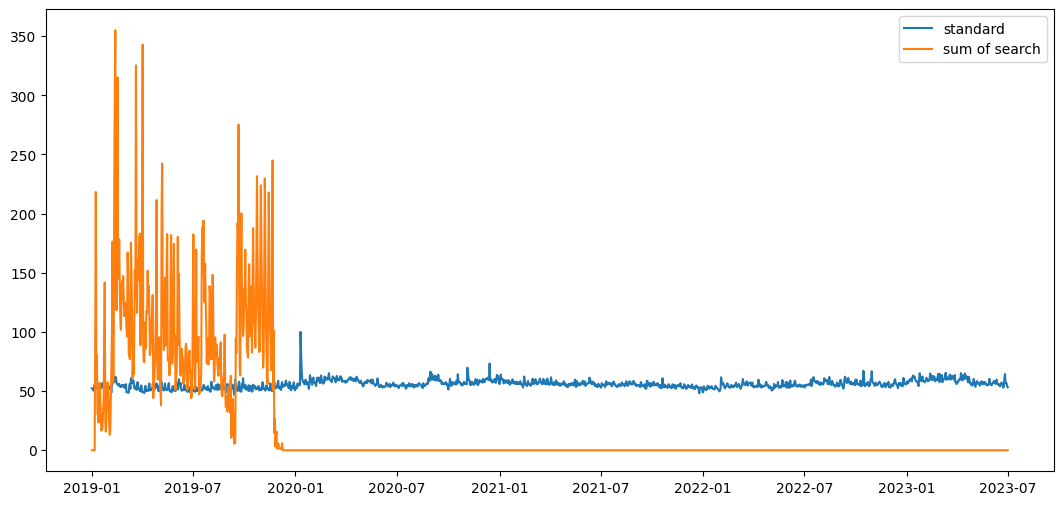

In [ ]:
plt.figure(figsize = (13, 6))
plt.plot(drama_search.index, drama_search['기준'], label = 'standard')
plt.plot(drama_search.index, drama_search['sum_search'], label = 'sum of search')
plt.legend()
plt.show()

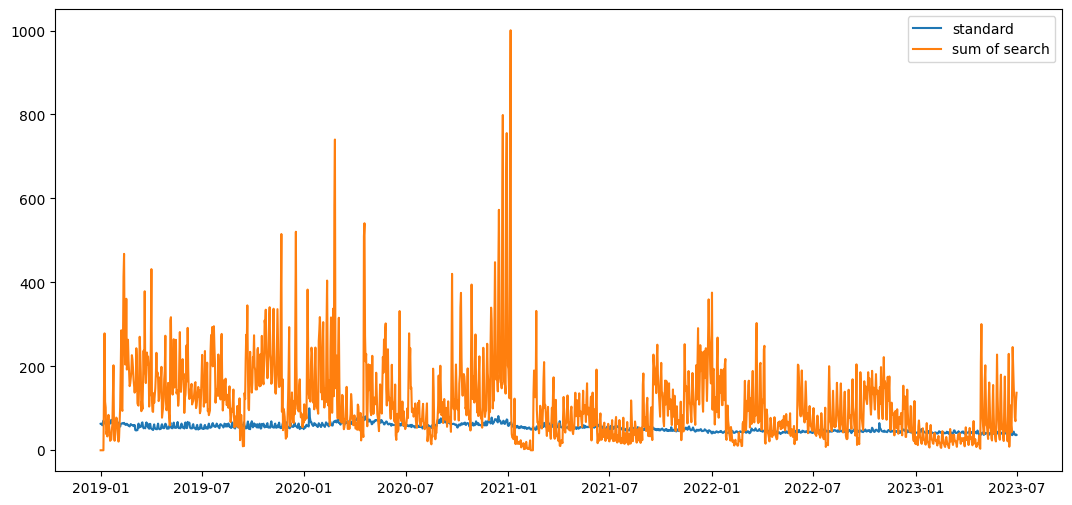

In [ ]:
plt.figure(figsize = (13, 6))
plt.plot(drama_search.index, drama_search['기준'], label = 'standard')
plt.plot(drama_search.index, drama_search['avg_search'], label = 'sum of search')
plt.legend()
plt.show()

# 시청률과 검색량의 간극 - 9시 이후 + 단막극 제거(10화 이상만)

## 검색 전처리

In [ ]:
# 9시 반부터 10시 반까지
night_list = meta.loc[(meta['시작시간'] >= time(9, 0)) & (meta['전체회차'] >= 10), '작품명'].tolist()

In [ ]:
translator = str.maketrans('', '', f'{string.punctuation} ')
# 특수문자 지우고, : 이나 -로 부제 달린 것들은 앞에 것만 반영
x_list = [[x, x.split(':')[0], x.split('-')[0], x.translate(translator)] for x in night_list]

# 동일한 인자는 지우기
detail_list = []
for sub_list in x_list:
    detail_list.append(list(set(sub_list)))
    detail_list_2 = detail_list.copy()
print(detail_list_2)

[['최고의 치킨', '최고의치킨'], ['동네변호사조들호2죄와벌', '동네변호사 조들호 2', '동네변호사 조들호 2: 죄와 벌'], ['왕이된남자', '왕이 된 남자'], ['왜그래 풍상씨', '왜그래풍상씨'], ['봄이 오나 봄', '봄이오나봄'], ['로맨스는별책부록', '로맨스는 별책부록'], ['바벨'], ['진심이 닿다', '진심이닿다'], ['리갈하이', '리갈 하이'], ['막돼먹은 영애씨 17', '막돼먹은영애씨17'], ['눈이부시게', '눈이 부시게'], ['아이템'], ['해치'], ['열혈사제'], ['슬플 때 사랑한다', '슬플때사랑한다'], ['빅이슈'], ['빙의'], ['사이코메트리그녀석', '사이코메트리 그녀석'], ['닥터프리즈너', '닥터 프리즈너'], ['킬잇'], ['자백'], ['으라차차와이키키2', '으라차차 와이키키 2'], ['더뱅커', '더 뱅커'], ['국민 여러분!', '국민여러분'], ['아름다운세상', '아름다운 세상'], ['특별근로감독관조장풍', '특별근로감독관 조장풍'], ['회사가기싫어', '회사 가기 싫어'], ['그녀의 사생활', '그녀의사생활'], ['녹두꽃'], ['이몽'], ['어비스'], ['초면에 사랑합니다', '초면에사랑합니다'], ['구해줘 2', '구해줘2'], ['보이스 3 ', '보이스 3 - 공범들의 도시', '보이스3공범들의도시'], ['절대 그이', '절대그이'], ['단하나의사랑', '단, 하나의 사랑'], ['바람이분다', '바람이 분다'], ['아스달 연대기', '아스달연대기'], ['퍼퓸'], ['검색어를입력하세요WWW', '검색어를 입력하세요 WWW'], ['조선생존기'], ['보좌관'], ['60일지정생존자', '60일, 지정생존자'], ['평일오후세시의연인', '평일 오후 세시의 연인'], ['왓쳐'], ['레벨업'], ['호텔 델루나', '호텔델루나'], ['미스터 기간제', '미스터기간제'], ['저스티스'], ['닥터 탐정', '닥터탐정'], ['의사요

In [ ]:
modify_detail('동네변호사 조들호 2', '동네변호사 조들호')
modify_detail('검색어를 입력하세요 WWW', '검블유')
modify_detail('싸이코패스 다이어리', '싸패다')
modify_detail('왜 오수재인가?', '왜오수재인가')
modify_detail('금혼령, 조선 혼인 금지령', '금혼령')
modify_detail('낭만닥터 김사부 3', '김사부 3')


modify_detail('조선로코', 'ㅇㄹ', add = False)
modify_detail('보쌈 ', 'ㅇㄹ', add = False)
detail_list[67] = ['조선로코 녹두전', '녹두전', '조선로코-녹두전']
detail_list[172] = ['보쌈 - 운명을 훔치다', '보쌈 운명을 훔치다']

1 ['동네변호사조들호2죄와벌', '동네변호사 조들호 2', '동네변호사 조들호 2: 죄와 벌']
['동네변호사조들호2죄와벌', '동네변호사 조들호 2', '동네변호사 조들호 2: 죄와 벌', '동네변호사 조들호']
39 ['검색어를입력하세요WWW', '검색어를 입력하세요 WWW']
['검색어를입력하세요WWW', '검색어를 입력하세요 WWW', '검블유']
75 ['싸이코패스다이어리', '싸이코패스 다이어리']
['싸이코패스다이어리', '싸이코패스 다이어리', '싸패다']
246 ['왜 오수재인가?', '왜오수재인가']
['왜 오수재인가?', '왜오수재인가', '왜오수재인가']
279 ['금혼령조선혼인금지령', '금혼령, 조선 혼인 금지령']
['금혼령조선혼인금지령', '금혼령, 조선 혼인 금지령', '금혼령']
302 ['낭만닥터김사부3', '낭만닥터 김사부 3']
['낭만닥터김사부3', '낭만닥터 김사부 3', '김사부 3']
67 ['조선로코', '조선로코-녹두전', '조선로코녹두전']
172 ['보쌈 - 운명을 훔치다', '보쌈운명을훔치다', '보쌈 ']


In [ ]:
modify_detail('펜트하우스', '펜하')
modify_detail('펜트하우스2', '펜하')
modify_detail('펜트하우스3', '펜하')
modify_detail('펜트하우스2', '펜하2')
modify_detail('펜트하우스3', '펜하3')
modify_detail('펜트하우스2', '펜트하우스')
modify_detail('펜트하우스3', '펜트하우스')
modify_detail('어느날우리집현관으로문으로멸망이들어왔다', '어느날멸망이')
modify_detail('이번생도잘부탁해', '이생잘')
modify_detail('막돼먹은영애씨17', '막되먹은영애씨')


140 ['펜트하우스']
['펜트하우스', '펜하']
159 ['펜트하우스 2', '펜트하우스2']
['펜트하우스 2', '펜트하우스2', '펜하']
179 ['펜트하우스 3', '펜트하우스3']
['펜트하우스 3', '펜트하우스3', '펜하']
159 ['펜트하우스 2', '펜트하우스2', '펜하']
['펜트하우스 2', '펜트하우스2', '펜하', '펜하2']
179 ['펜트하우스 3', '펜트하우스3', '펜하']
['펜트하우스 3', '펜트하우스3', '펜하', '펜하3']
159 ['펜트하우스 2', '펜트하우스2', '펜하', '펜하2']
['펜트하우스 2', '펜트하우스2', '펜하', '펜하2', '펜트하우스']
179 ['펜트하우스 3', '펜트하우스3', '펜하', '펜하3']
['펜트하우스 3', '펜트하우스3', '펜하', '펜하3', '펜트하우스']
306 ['이번 생도 잘 부탁해', '이번생도잘부탁해']
['이번 생도 잘 부탁해', '이번생도잘부탁해', '이생잘']
9 ['막돼먹은 영애씨 17', '막돼먹은영애씨17']
['막돼먹은 영애씨 17', '막돼먹은영애씨17', '막되먹은영애씨']


## 시청률

<ipython-input-12-35787d3c4880>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = rate[rate['작품명'].isin(night_list)].groupby('방송일자').mean()['시청률'].reset_index()


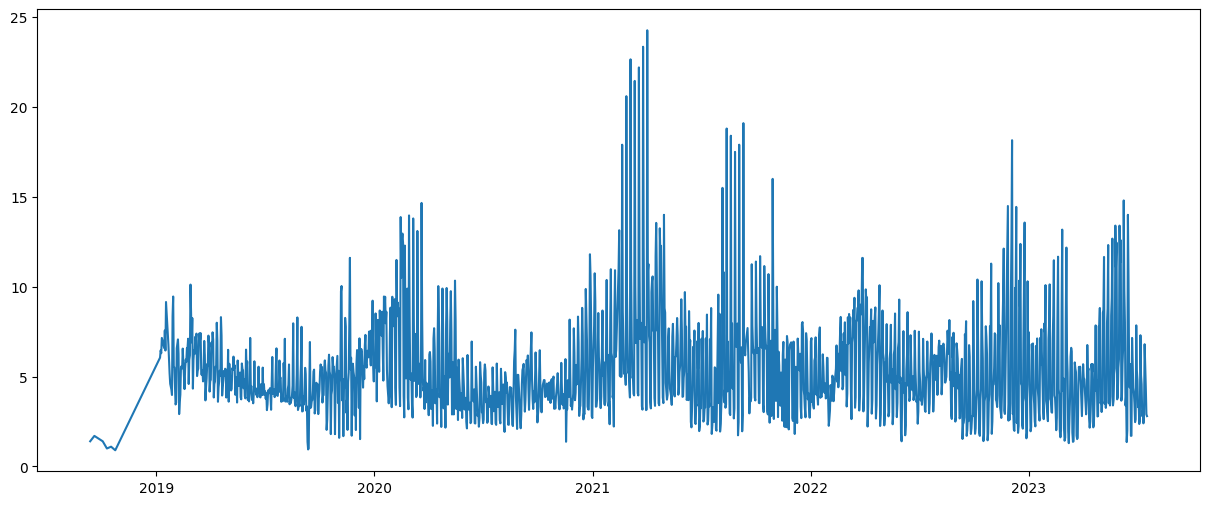

In [ ]:
x = rate[rate['작품명'].isin(night_list)].groupby('방송일자').mean()['시청률'].reset_index()

plt.figure(figsize = (15, 6))
plt.plot(x['방송일자'], x['시청률'])
plt.show()

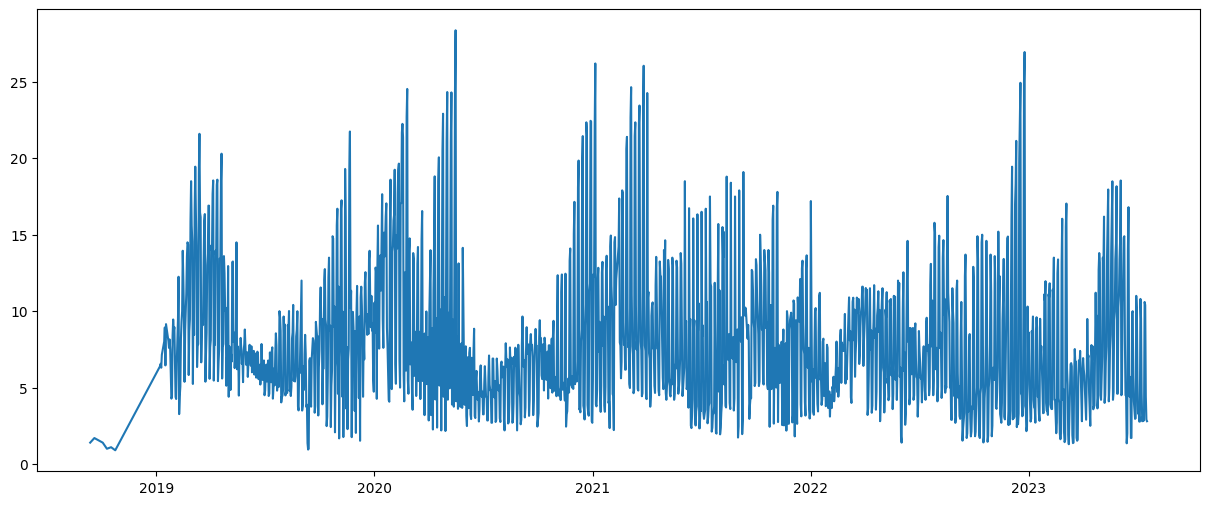

In [ ]:
y = rate[rate['작품명'].isin(night_list)].groupby('방송일자').max()['시청률'].reset_index()
plt.figure(figsize = (15, 6))
plt.plot(y['방송일자'], y['시청률'])
plt.show()

## 검색 코드

In [ ]:
# 비교 기준과 병합용 table
standard = df_search(['기준'], [['구글']], '2019-01-01', '2023-07-01', ages = '', gender = '')
whole_join = standard.copy().set_index('period')


# night_list, detail_list 는 야간의 작품명들과 그것들의 세부 검색어 집합
for a in tqdm(range(len(night_list))):
  # df_search의 인자
  title = night_list[a]
  details = [detail_list[a], ['구글']]
  ages = ''
  gender = ''
  keyword, startdate, enddate = return_search_info(title)
  # 7월까지로 데이터 제한
  if enddate < '2023-07-01':
    pass
  else:
    enddate = '2023-07-01'

  # 비교가 가능하도록 조정
  t.sleep(0.1)
  k = df_search(keyword, details, startdate, enddate, ages, gender)
  value = standard.loc[standard['period'] == k.iloc[0,0], '기준'] / k.iloc[0,2]
  value = value.values[0]

  k.iloc[:, 1] = k.iloc[:, 1]*value

  whole_join = whole_join.join(k.iloc[:, :2].set_index('period'))


100%|██████████| 313/313 [05:46<00:00,  1.11s/it]


In [ ]:
# whole_join.to_csv('/content/whole_join.csv', encoding = 'utf-8-sig')
whole_join = pd.read_csv('/content/whole_join.csv', parse_dates = ['period'])

In [ ]:
whole_join['sum_search'] = whole_join.iloc[:, 2:].sum(axis=1)
drama_search= whole_join[['period', '기준', 'sum_search']]

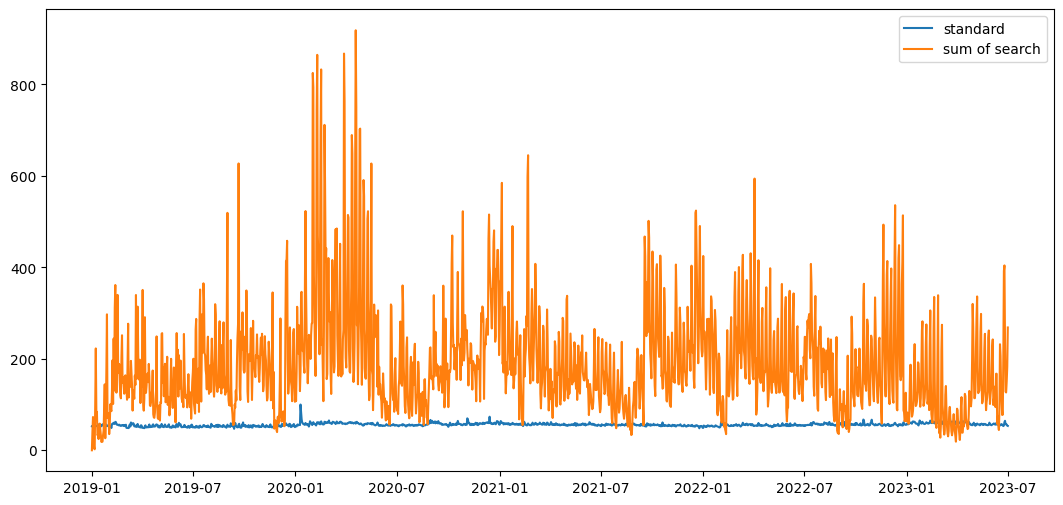

In [ ]:
plt.figure(figsize = (13, 6))
plt.plot(drama_search['period'], drama_search['기준'], label = 'standard')
plt.plot(drama_search['period'], drama_search['sum_search'], label = 'sum of search')
plt.legend()
plt.show()

# 시청률과 검색량

## 분포 퍼센티지

<ipython-input-40-357e42ce0b5b>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rate = rate.loc[rate['작품명'].isin(night_title)].groupby('작품명').mean().reset_index()


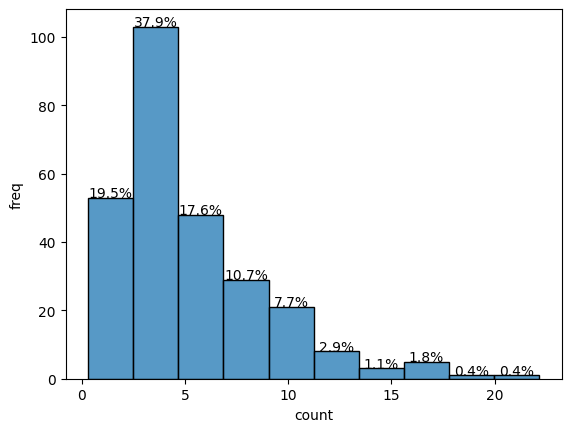

In [ ]:
### 시청률 분포 확인 ###
night_title = meta.loc[(meta['시작시간'] >= time(9, 0)) & (meta['전체회차'] >= 10), '작품명'].tolist()
avg_rate = rate.loc[rate['작품명'].isin(night_title)].groupby('작품명').mean().reset_index()

# seaborn을 이용하여 히스토그램 그리기
sns.histplot(avg_rate['시청률'], bins=10, kde=False)

# matplotlib의 기능을 이용하여 각 바의 높이와 위치를 구하고, 전체 바의 높이 합계를 구하기
total = 0
for rect in plt.gca().patches:
    height = rect.get_height()
    total += height

# 각 바 위에 텍스트 표시하기
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height + 0.1,
             '{:.1f}%'.format(100 * height/total), ha='center')

# x축과 y축 라벨 추가
plt.xlabel('count')
plt.ylabel('freq')

plt.show()


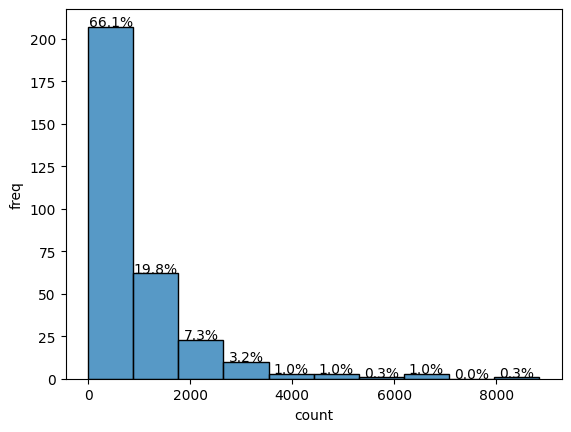

In [ ]:
searchs = whole_join.iloc[:, 2:-1].sum()
searchs = pd.DataFrame(searchs, columns = ['searchs']).reset_index()

sns.histplot(searchs['searchs'], bins=10, kde=False)

# matplotlib의 기능을 이용하여 각 바의 높이와 위치를 구하고, 전체 바의 높이 합계를 구하기
total = 0
for rect in plt.gca().patches:
    height = rect.get_height()
    total += height

# 각 바 위에 텍스트 표시하기
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2., height + 0.1,
             '{:.1f}%'.format(100 * height/total), ha='center')

# x축과 y축 라벨 추가
plt.xlabel('count')
plt.ylabel('freq')

plt.show()


## 시청률과 검색량 상관계수 분석

### 데이터 전체를 사용하는 경우 : 상관관계 유의

In [ ]:
total = avg_rate.merge(searchs, left_on='작품명', right_on='index').drop('index', axis = 1)

<ipython-input-175-11de9349bbe3>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x='시청률', y='searchs', data=total, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


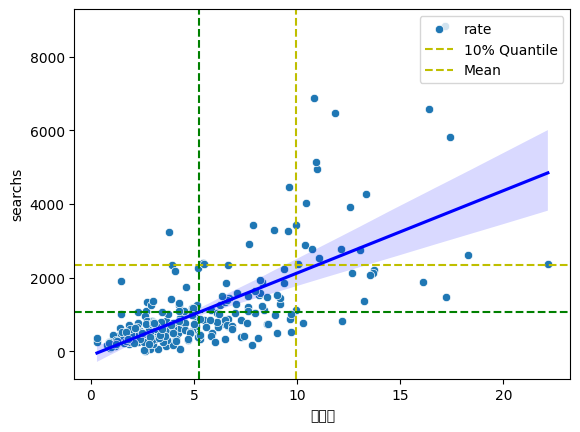

In [ ]:
# '방영연도' 열을 정수로 변환
total['방영연도'] = total['방영연도'].astype(int)

# 각 열의 10% 수준에 해당하는 값과 평균 계산
quantile_10 = total[['시청률', 'searchs']].quantile(0.9)
mean = total[['시청률', 'searchs']].mean()

# '방영연도' 열을 hue로 하는 산점도 그리기
ax = sns.scatterplot(x='시청률', y='searchs', data=total, palette='viridis')

# 각 열의 10% 수준에 해당하는 선 그리기
ax.axvline(x=quantile_10['시청률'], color='y', linestyle='--')
ax.axhline(y=quantile_10['searchs'], color='y', linestyle='--')

# 각 열의 평균에 해당하는 선 그리기
ax.axvline(x=mean['시청률'], color='g', linestyle='--')
ax.axhline(y=mean['searchs'], color='g', linestyle='--')

# 회귀선 추가하기
sns.regplot(x='시청률', y='searchs', data=total, scatter=False, ax=ax, color='b')

# 범례 추가. 여기서 범례 레이블을 지정합니다.
ax.legend(labels=['rate', '10% Quantile', 'Mean'])

plt.show()


In [ ]:
# 시청률에 대한 정규성 검정
stat, p_value = shapiro(total['시청률'])
print('시청률 - Statistics=%.3f, p=%.3f' % (stat, p_value))

# searchs에 대한 정규성 검정
stat, p_value = shapiro(total['searchs'])
print('Searchs - Statistics=%.3f, p=%.3f' % (stat, p_value))

# 등분산성 검정
stat, p_value = levene(total['시청률'], total['searchs'])
print('LeveneResult Statistics=%.3f, p=%.3f' % (stat, p_value))

# => 정규분포도 아니고 두 분산이 동일하지 않다.

시청률 - Statistics=0.873, p=0.000
Searchs - Statistics=0.665, p=0.000
LeveneResult Statistics=108.385, p=0.000


In [ ]:
# spearman 상관계수 분석
rho, p_value = spearmanr(total['시청률'], total['searchs'])

print('Spearman correlation: %.3f' % rho)
print('p-value: %.3f' % p_value)
# 유의하다

Spearman correlation: 0.685
p-value: 0.000


### 둘 모두 하위 90% 데이터만 사용하는 경우 : 상관관계 유의

In [ ]:
total_under_10 = total.loc[(total['시청률'] <= quantile_10[0]) & (total['searchs'] <= quantile_10[1])]

<ipython-input-179-d56f8982f03e>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x='시청률', y='searchs', data=total_under_10, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


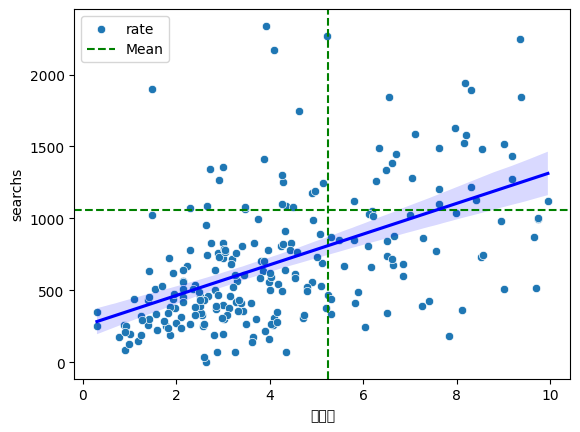

In [ ]:

ax = sns.scatterplot(x='시청률', y='searchs', data=total_under_10, palette='viridis')

# 각 열의 평균에 해당하는 선 그리기
ax.axvline(x=mean['시청률'], color='g', linestyle='--')
ax.axhline(y=mean['searchs'], color='g', linestyle='--')

# 회귀선 추가하기
sns.regplot(x='시청률', y='searchs', data=total_under_10, scatter=False, ax=ax, color='b')

# 범례 추가. 여기서 범례 레이블을 지정합니다.
ax.legend(labels=['rate', 'Mean'])

plt.show()


In [ ]:
# 시청률에 대한 정규성 검정
stat, p_value = shapiro(total_under_10['시청률'])
print('시청률 - Statistics=%.3f, p=%.3f' % (stat, p_value))

# searchs에 대한 정규성 검정
stat, p_value = shapiro(total_under_10['searchs'])
print('Searchs - Statistics=%.3f, p=%.3f' % (stat, p_value))

# 등분산성 검정
stat, p_value = levene(total_under_10['시청률'], total_under_10['searchs'])
print('LeveneResult Statistics=%.3f, p=%.3f' % (stat, p_value))

# => 정규분포도 아니고 두 분산이 동일하지 않다.

시청률 - Statistics=0.941, p=0.000
Searchs - Statistics=0.907, p=0.000
LeveneResult Statistics=275.058, p=0.000


In [ ]:
# spearman 상관계수 분석
rho, p_value = spearmanr(total_under_10['시청률'], total_under_10['searchs'])

print('Spearman correlation: %.3f' % rho)
print('p-value: %.3f' % p_value)
# 유의하다

Spearman correlation: 0.560
p-value: 0.000


### 상위 10% 데이터만 보는 경우 : 상관관계 유의 X

<ipython-input-182-cdbbb44fe54f>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x='시청률', y='searchs', data=total_up_10, palette='viridis')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


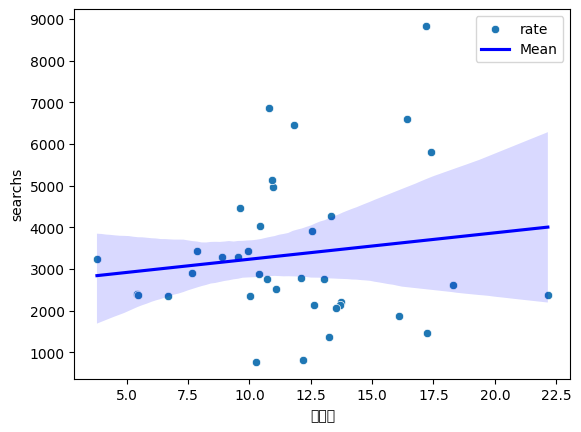

In [ ]:
total_up_10 = total.loc[(total['시청률'] > quantile_10[0]) | (total['searchs'] > quantile_10[1])]


ax = sns.scatterplot(x='시청률', y='searchs', data=total_up_10, palette='viridis')

# 회귀선 추가하기
sns.regplot(x='시청률', y='searchs', data=total_up_10, scatter=False, ax=ax, color='b')

# 범례 추가. 여기서 범례 레이블을 지정합니다.
ax.legend(labels=['rate', 'Mean'])

plt.show()


#### 영역별 검정

In [ ]:
# 시청률에 대한 정규성 검정
stat, p_value = shapiro(total_up_10['시청률'])
print('시청률 - Statistics=%.3f, p=%.3f' % (stat, p_value))

# searchs에 대한 정규성 검정
stat, p_value = shapiro(total_up_10['searchs'])
print('Searchs - Statistics=%.3f, p=%.3f' % (stat, p_value))

# 등분산성 검정
stat, p_value = levene(total_up_10['시청률'], total_up_10['searchs'])
print('LeveneResult Statistics=%.3f, p=%.3f' % (stat, p_value))

# => 정규분포도 아니고 두 분산이 동일하지 않다.

시청률 - Statistics=0.975, p=0.573
Searchs - Statistics=0.897, p=0.002
LeveneResult Statistics=31.102, p=0.000


In [ ]:
# spearman 상관계수 분석; 귀무가설 : 유의하지 않다. o.value > 0.05이므로 기각 불가
rho, p_value = spearmanr(total_up_10['시청률'], total_up_10['searchs'])

print('Spearman correlation: %.3f' % rho)
print('p-value: %.3f' % p_value)
# 유의하다

Spearman correlation: -0.095
p-value: 0.575


In [ ]:
total_up_10_1 = total.loc[(total['시청률'] > quantile_10[0])]

stat, p_value = shapiro(total_up_10_1['시청률'])
print('시청률 - Statistics=%.3f, p=%.3f' % (stat, p_value))

# searchs에 대한 정규성 검정
stat, p_value = shapiro(total_up_10_1['searchs'])
print('Searchs - Statistics=%.3f, p=%.3f' % (stat, p_value))

# 등분산성 검정
stat, p_value = levene(total_up_10_1['시청률'], total_up_10_1['searchs'])
print('LeveneResult Statistics=%.3f, p=%.3f' % (stat, p_value))

rho, p_value = spearmanr(total_up_10_1['시청률'], total_up_10_1['searchs'])

print('Spearman correlation: %.3f' % rho)
print('p-value: %.3f' % p_value)

시청률 - Statistics=0.878, p=0.004
Searchs - Statistics=0.905, p=0.015
LeveneResult Statistics=26.978, p=0.000
Spearman correlation: -0.084
p-value: 0.670


In [ ]:
total_up_10_2 = total.loc[(total['searchs'] > quantile_10[1])]

stat, p_value = shapiro(total_up_10_2['시청률'])
print('시청률 - Statistics=%.3f, p=%.3f' % (stat, p_value))

# searchs에 대한 정규성 검정
stat, p_value = shapiro(total_up_10_2['searchs'])
print('Searchs - Statistics=%.3f, p=%.3f' % (stat, p_value))

# 등분산성 검정
stat, p_value = levene(total_up_10_2['시청률'], total_up_10_2['searchs'])
print('LeveneResult Statistics=%.3f, p=%.3f' % (stat, p_value))

rho, p_value = spearmanr(total_up_10_2['시청률'], total_up_10_2['searchs'])

print('Spearman correlation: %.3f' % rho)
print('p-value: %.3f' % p_value)

시청률 - Statistics=0.948, p=0.177
Searchs - Statistics=0.837, p=0.001
LeveneResult Statistics=23.859, p=0.000
Spearman correlation: 0.313
p-value: 0.105


In [ ]:
total_up_10_3 = total.loc[(total['시청률'] > quantile_10[0]) & (total['searchs'] > quantile_10[1])]

stat, p_value = shapiro(total_up_10_3['시청률'])
print('시청률 - Statistics=%.3f, p=%.3f' % (stat, p_value))

# searchs에 대한 정규성 검정
stat, p_value = shapiro(total_up_10_3['searchs'])
print('Searchs - Statistics=%.3f, p=%.3f' % (stat, p_value))

# 등분산성 검정
stat, p_value = levene(total_up_10_3['시청률'], total_up_10_3['searchs'])
print('LeveneResult Statistics=%.3f, p=%.3f' % (stat, p_value))

rho, p_value = spearmanr(total_up_10_3['시청률'], total_up_10_3['searchs'])

print('Spearman correlation: %.3f' % rho)
print('p-value: %.3f' % p_value)

시청률 - Statistics=0.819, p=0.002
Searchs - Statistics=0.881, p=0.022
LeveneResult Statistics=32.096, p=0.000
Spearman correlation: 0.105
p-value: 0.668


#### 분석

In [ ]:
# 하위 90%와 달리 상관성이 나타나지 않는다. 왜 그럴까? ott의 존재..?

up10_list = total_up_10['작품명'].tolist()

# 협찬 검색

In [ ]:
# meta = pd.read_csv('/content/메타_전처리1.csv')
total_up_10_main = total_up_10[['작품명', '시청률', 'searchs']]
total_up_10_main = total_up_10_main.merge(meta.loc[meta['작품명'].isin(up10_list), ['작품명', '출연자']], on = '작품명')

In [ ]:
total_up_10_main

In [ ]:
fashion = ['패션', '옷', '립스틱']

In [ ]:
#리스트로 바꾸기
up10_list = total_up_10_main['작품명'].tolist()
up10_actor_list = total_up_10_main['출연자'].apply(ast.literal_eval).tolist()

# 패션 아이템 리스트
fashion = ['패션', '옷', '립스틱']

# 3중 리스트 생성
final_list = []
for drama, actor_list in zip(up10_list, up10_actor_list):
    drama_actor_fashion_list = []
    for actor in actor_list:
        actor_fashion_list = []
        for fashion_item in fashion:
            actor_fashion_list.append(f"{drama} {actor} {fashion_item}")
        drama_actor_fashion_list.append(actor_fashion_list)
    final_list.append(drama_actor_fashion_list)

In [ ]:
final_list # 장르, 드라마 자체의 시청률, 배우의 클래스

[[['갯마을 차차차 신민아 패션', '갯마을 차차차 신민아 옷', '갯마을 차차차 신민아 립스틱'],
  ['갯마을 차차차  김선호 패션', '갯마을 차차차  김선호 옷', '갯마을 차차차  김선호 립스틱'],
  ['갯마을 차차차  이상이  패션', '갯마을 차차차  이상이  옷', '갯마을 차차차  이상이  립스틱']],
 [['경이로운 소문 조병규 패션', '경이로운 소문 조병규 옷', '경이로운 소문 조병규 립스틱'],
  ['경이로운 소문  유준상 패션', '경이로운 소문  유준상 옷', '경이로운 소문  유준상 립스틱'],
  ['경이로운 소문  김세정 패션', '경이로운 소문  김세정 옷', '경이로운 소문  김세정 립스틱'],
  ['경이로운 소문  염혜란 패션', '경이로운 소문  염혜란 옷', '경이로운 소문  염혜란 립스틱'],
  ['경이로운 소문  안석환 패션', '경이로운 소문  안석환 옷', '경이로운 소문  안석환 립스틱'],
  ['경이로운 소문  이홍내 패션', '경이로운 소문  이홍내 옷', '경이로운 소문  이홍내 립스틱'],
  ['경이로운 소문  옥자연 패션', '경이로운 소문  옥자연 옷', '경이로운 소문  옥자연 립스틱'],
  ['경이로운 소문  정원창 패션', '경이로운 소문  정원창 옷', '경이로운 소문  정원창 립스틱'],
  ['경이로운 소문  최광일  패션', '경이로운 소문  최광일  옷', '경이로운 소문  최광일  립스틱']],
 [['낭만닥터 김사부 2 한석규 패션', '낭만닥터 김사부 2 한석규 옷', '낭만닥터 김사부 2 한석규 립스틱'],
  ['낭만닥터 김사부 2  안효섭 패션', '낭만닥터 김사부 2  안효섭 옷', '낭만닥터 김사부 2  안효섭 립스틱'],
  ['낭만닥터 김사부 2  이성경 패션', '낭만닥터 김사부 2  이성경 옷', '낭만닥터 김사부 2  이성경 립스틱'],
  ['낭만닥터 김사부 2  김주헌  패션', '낭만닥터 김사부 2  김주헌  옷', '낭만닥터 김사부 2